# Create ROMS bathymetry grid

In [1]:
import cftime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from scipy import interpolate
from scipy import io
from scipy import ndimage
import xarray as xr
import cmocean 

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
# Load mission 19 to get the metadata of the mission
mission_nc_path = './mission_data/mission_19.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')
mission19_time = np.median(mission_dataset['time'][:])
mission19_time_datetime = cftime.num2pydate(mission19_time, 
                                     units=mission_dataset['time'].units, 
                                     calendar=mission_dataset['time'].calendar)

mission_df_8m = pd.read_csv('./mission_data/mission_df.csv')

/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


50.0
950.0
-100.0
1100.0


Text(0, 0.5, 'Along Shore [m]')

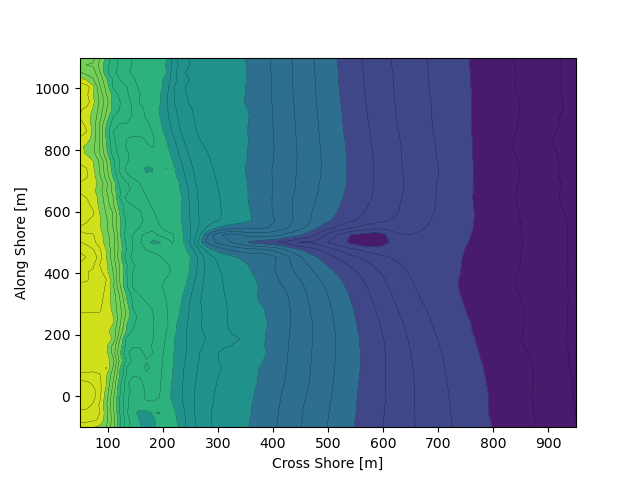

In [3]:
# Load basic processed bathymetry
bathy_basic_data = nc.Dataset('./bathy_data/FRF_geomorphology_DEMs_surveyDEM_20211021.nc')
xFRF = bathy_basic_data['xFRF'][:]
yFRF = bathy_basic_data['yFRF'][:]
bathy_x_grid, bathy_y_grid = np.meshgrid(xFRF, yFRF)
elevation_basic = bathy_basic_data['elevation'][0,:,:]
print(np.min(xFRF))
print(np.max(xFRF))
print(np.min(yFRF))
print(np.max(yFRF))

fig, ax = plt.subplots()
ax.contourf(bathy_x_grid, bathy_y_grid, elevation_basic)
ax.contour(bathy_x_grid, bathy_y_grid, elevation_basic, colors='k', levels=25, linewidths=0.2)
ax.set_xlabel('Cross Shore [m]')
ax.set_ylabel('Along Shore [m]')

In [54]:
# Define grid cell edge size
x_cgrid_size = 1 # units are meters
y_cgrid_size = 3 # units are meters

# Define grid edges
x_cgrid_min = 50
x_cgrid_max = 950
y_cgrid_min = -1200
y_cgrid_max = 1800

# Bathymetry Survey Data closest to Mission 19
bathy_20211008 = nc.Dataset('./bathy_data/FRF_geomorphology_elevationTransects_survey_20211008.nc')

# Get the point cloud data from the transect file
xFRF_survey_points = bathy_20211008['xFRF'][:]
yFRF_survey_points = bathy_20211008['yFRF'][:]
elevation_survey_points = bathy_20211008['elevation'][:]

# Define number of points based on grid size
num_x_points = int((x_cgrid_max - x_cgrid_min) / x_cgrid_size)
num_y_points = int((y_cgrid_max - y_cgrid_min) / y_cgrid_size)

# Create mesh grid
x_cgrid, y_cgrid = np.meshgrid(np.linspace(x_cgrid_min, x_cgrid_max, num_x_points),
                               np.linspace(y_cgrid_min, y_cgrid_max, num_y_points))

# Regrid the DEM to match the new spatial grid
h_grid= interpolate.interpn((xFRF, yFRF), elevation_basic.T, (x_cgrid, y_cgrid), method='linear',
                                           bounds_error=False, fill_value=np.NaN)

# Find upper and lower edge cross shore transects that are not NaNs
upper_edge_nonan_ind = np.max(np.where(~np.isnan(h_grid[:,0])))
lower_edge_nonan_ind = np.min(np.where(~np.isnan(h_grid[:,0])))

# Compute the average bathymetry profile between the top and bottom of the grid
mean_profile_for_grid_edges = (h_grid[upper_edge_nonan_ind,:] + h_grid[lower_edge_nonan_ind,:]) / 2

# Set the grid upper and lower edges as the mean profile
h_grid[-1,:] = mean_profile_for_grid_edges
h_grid[0,:] = mean_profile_for_grid_edges 

# Interpolate between the mean profile at the edges and the last measured profiles
for n in range(h_grid.shape[1]):
    # Fill in upper grid points
    h_grid[upper_edge_nonan_ind:-1,n] = np.interp(y_cgrid[upper_edge_nonan_ind:-1,n],
                                                [y_cgrid[upper_edge_nonan_ind,n], y_cgrid[-1,n]],
                                                [h_grid[upper_edge_nonan_ind,n], h_grid[-1,n]])
    # Fill in lower grid points
    h_grid[0:lower_edge_nonan_ind,n] = np.interp(y_cgrid[0:lower_edge_nonan_ind,n],
                                                [y_cgrid[0,n], y_cgrid[lower_edge_nonan_ind,n]],
                                                [h_grid[0,n], h_grid[lower_edge_nonan_ind,n]])
    
# Fill the grid points closest to the surveyed points with the surveyed bathymetry
for n in range(elevation_survey_points.size):
    # closest x and y points in the array
    x_index = np.searchsorted(x_cgrid[0,:], xFRF_survey_points[n])
    y_index = np.searchsorted(y_cgrid[:,0], yFRF_survey_points[n])
    # Fill the grid with the survey point
    h_grid[y_index, x_index] = elevation_survey_points[n]
    
# Smooth the Bathymetry
h_grid_smoothed = ndimage.gaussian_filter(h_grid, sigma=2)

# ## DO THIS STEP AGAIN TO MAKE SURE THE UPPER AN LOWER EDGES MATCH AFTER SMOOTHING
# Compute the average bathymetry profile between the top and bottom of the grid
mean_profile_for_grid_edges = (h_grid[upper_edge_nonan_ind,:] + h_grid[lower_edge_nonan_ind,:]) / 2

# Set the grid upper and lower edges as the mean profile
h_grid_smoothed[-1,:] = mean_profile_for_grid_edges
h_grid_smoothed[0,:] = mean_profile_for_grid_edges 

# Interpolate between the mean profile at the edges and the last measured profiles
for n in range(h_grid_smoothed.shape[1]):
    # Fill in upper grid points
    h_grid_smoothed[upper_edge_nonan_ind:-1,n] = np.interp(y_cgrid[upper_edge_nonan_ind:-1,n],
                                                [y_cgrid[upper_edge_nonan_ind,n], y_cgrid[-1,n]],
                                                [h_grid_smoothed[upper_edge_nonan_ind,n], h_grid_smoothed[-1,n]])
    # Fill in lower grid points
    h_grid_smoothed[0:lower_edge_nonan_ind,n] = np.interp(y_cgrid[0:lower_edge_nonan_ind,n],
                                                [y_cgrid[0,n], y_cgrid[lower_edge_nonan_ind,n]],
                                                [h_grid_smoothed[0,n], h_grid_smoothed[lower_edge_nonan_ind,n]])

In [52]:
# Test that the survey points are going to the correct place
n = 100
# X Values
x_index = np.searchsorted(x_cgrid[0,:], xFRF_survey_points[n])

print(f'Survey x point: {xFRF_survey_points[n]}')
print(f'grid x point: {x_cgrid[0,:][x_index]}')

# Y Values
y_index = np.searchsorted(y_cgrid[:,0], yFRF_survey_points[n])

print(f'Survey y point: {y_cgrid[:,0][y_index]}')
print(f'grid y point: {yFRF_survey_points[n]}')
print(f'Grid Point for x: {x_cgrid[y_index,x_index]}')
print(f'Grid Point for y: {y_cgrid[y_index,x_index]}')

Survey x point: 105.307
grid x point: 106.06229143492769
Survey y point: 640.8408408408407
grid y point: 639.132
Grid Point for x: 106.06229143492769
Grid Point for y: 640.8408408408407


(50.0, 950.0, -1200.0, 1800.0)

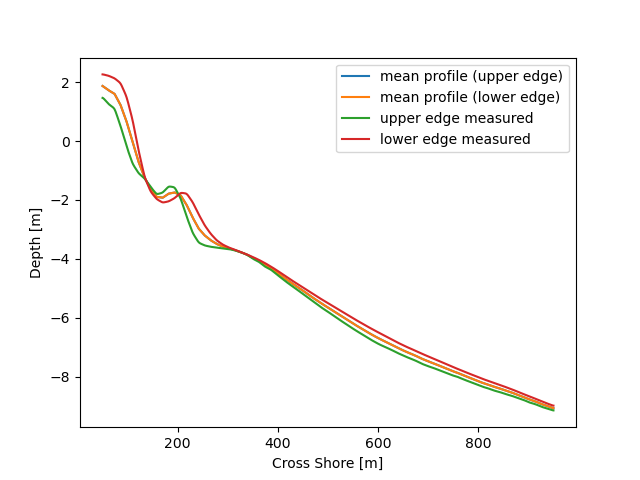

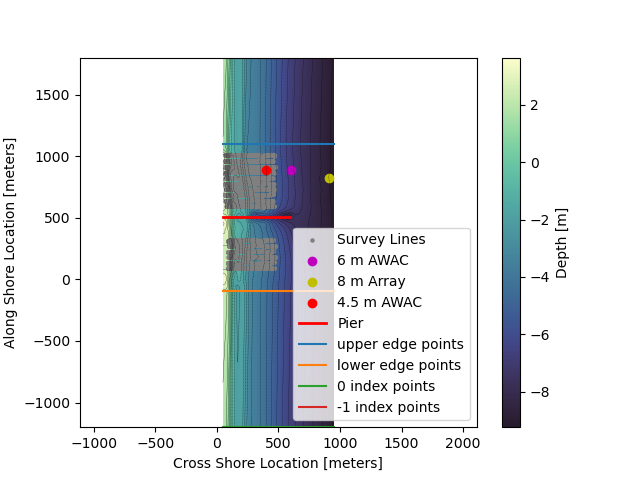

In [55]:
# Plot the Upper and Lower measured Bathy profiles and the mean profile
fig, ax = plt.subplots()
ax.plot(x_cgrid[0,:], h_grid_smoothed[-1,:], label='mean profile (upper edge)')
ax.plot(x_cgrid[0,:], h_grid_smoothed[0,:], label='mean profile (lower edge)')
ax.plot(x_cgrid[0,:], h_grid_smoothed[upper_edge_nonan_ind,:], label='upper edge measured')
ax.plot(x_cgrid[0,:], h_grid_smoothed[lower_edge_nonan_ind,:], label='lower edge measured')
ax.legend()
ax.set_xlabel('Cross Shore [m]')
ax.set_ylabel('Depth [m]')

# Plot the Smoother Bathymetry
fig, ax = plt.subplots()
im = ax.pcolormesh(x_cgrid, y_cgrid, h_grid_smoothed[:-1,:-1], shading='flat', cmap=cmocean.cm.deep_r)
ax.contour(x_cgrid, y_cgrid, h_grid_smoothed, colors='k', levels=25, linewidths=0.2)
ax.scatter(xFRF_survey_points, yFRF_survey_points, color='gray', s=5, label='Survey Lines')
cbar = fig.colorbar(im)
cbar.set_label('Depth [m]')
 # Figure properties
awac4p5m_location = [397.35, 890.98] # Converted from lat lon locations
                                     # published on FRF data portal
awac6m_location = [603.12, 886.68]   # Converted from lat lon locations published on FRF data portal
array8m_location = [914.05, 826.08]  # Nominal location based on published data even though this array has multiple locations
ax.scatter(awac6m_location[0], awac6m_location[1], color='m', label='6 m AWAC')
ax.scatter(array8m_location[0], array8m_location[1], color='y', label='8 m Array')
ax.scatter(awac4p5m_location[0],awac4p5m_location[1],
            color='r', label='4.5 m AWAC')
ax.set_aspect('equal')
ax.set_xlabel('Cross Shore Location [meters]')
ax.set_ylabel('Along Shore Location [meters]')
ax.plot([50,591],[510,510], linewidth=2, color='r', label='Pier')
ax.plot(x_cgrid[upper_edge_nonan_ind,:], y_cgrid[upper_edge_nonan_ind,:], label='upper edge points')
ax.plot(x_cgrid[lower_edge_nonan_ind,:], y_cgrid[lower_edge_nonan_ind,:], label='lower edge points')
ax.plot(x_cgrid[0,:], y_cgrid[0,:], label='0 index points')
ax.plot(x_cgrid[-1,:], y_cgrid[-1,:], label='-1 index points')
ax.legend()
ax.axis('equal')